# 01b_Auxtel Spectra and fit atmospheric parameters

- author Sylvie Dagoret-Campagne
- creation date : 2023/02/22
- last verification : 2023/02/22

<img src="../figs/logos/logo-IJCLab_v1.png" width="150" height="150"/> 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
#from matplotlib.gridspec import GridSpec

import matplotlib.dates as mdates
from matplotlib import gridspec
import pickle
import seaborn as sns
import copy
from collections import OrderedDict


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

import time
from datetime import datetime,date
from astropy.time import Time
from astropy.io import fits

In [2]:
from scipy import interpolate
from scipy.interpolate import interp1d

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import the fit tools

- import rubin sim

In [4]:
from importlib.metadata import version
the_ver = version('atmosphtransmemullsst')
print(f"Version of atmosphtransmemullsst : {the_ver}")

Version of atmosphtransmemullsst : 0.0.1


In [5]:
import sys
sys.path.append('../lib')
import libAtmosphericFit
from libauxtelspectra import *

libAtmosphericFit.py :: Use atmosphtransmemullsst.__path__[0],'../data/simplegrid as the path to data
libAtmosphericFit.py :: data_path = /Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid
SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [6]:
import atmosphtransmemullsst
from atmosphtransmemullsst.simpleatmospherictransparencyemulator import SimpleAtmEmulator

emul = SimpleAtmEmulator(os.path.join(atmosphtransmemullsst.__path__[0],'../data/simplegrid'))

SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [7]:
WL = emul.GetWL()

In [8]:
import sys
sys.path.append('../lib')
import libAtmosphericFit

In [9]:
import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

In [10]:
path_rubin_sim_throughput=os.path.join(os.getenv("HOME"),"rubin_sim_data/throughputs/baseline")
atm_std_filename = "atmos_std.dat"

## Configuration

In [11]:
filter_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

In [12]:
WLMINSEL=350.
WLMAXSEL=1050.
WLBIN=1.
NWLBIN=int((WLMAXSEL-WLMINSEL)/WLBIN)
WL=np.linspace(WLMINSEL,WLMAXSEL,NWLBIN)

In [13]:
FLUXLIMMAX= 1e-11
FLUXLIMMIN= 1e-13

In [14]:
the_date = 20220630
the_filtertype = "empty~holo4_003"
path_spectra = "../data/extractedspectraauxtel"
filename_spectra = "run-auxtel-holo-20220630-empty~holo4_003-PSF2DFFM_REBIN2-main.pickle"

In [15]:
DATE = the_date
SITE = "auxtel Rubin LSST"
filterdisperser = the_filtertype

In [16]:
# Must divide the observed flux by this correction area
correction_area = 1.06/1.13

# Initialisation

In [17]:
fullfilename=os.path.join(path_spectra,filename_spectra)

In [18]:
with open(fullfilename, 'rb') as f:
    spectra_content = pickle.load(f)

In [19]:
NBSPECTRA=len(spectra_content)

In [20]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [21]:
infos, all_spectra = GetSpectra(spectra_content)
list_of_badnums1 = []

In [22]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,45,HD142331,2022-06-30T23:14:17.706494693Z,0.000000,1.407330,0,0,0,2022063000045,309.943471,1750.306795,0.010239,180.214013
1,46,HD142331,2022-06-30T23:15:00.685003473Z,0.011938,1.403795,0,0,0,2022063000046,310.537392,1748.015570,0.014866,180.138312
2,60,HD142331,2022-06-30T23:24:09.982509252Z,0.164521,1.361241,0,0,0,2022063000060,306.231676,1747.407871,0.036551,180.229727
3,61,HD142331,2022-06-30T23:24:53.063496612Z,0.176488,1.358098,0,0,0,2022063000061,305.427041,1747.524377,0.037062,180.238926
4,76,HD185975,2022-06-30T23:35:28.838492749Z,0.353092,2.024822,0,0,0,2022063000076,308.087031,1756.460388,-0.157028,179.688370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,522,HD142331,2022-07-01T05:37:48.743502980Z,6.391955,1.723804,0,0,0,2022063000522,309.392723,1741.530979,-0.091309,180.123221
57,536,HD142331,2022-07-01T05:46:56.400994483Z,6.544082,1.810687,0,0,0,2022063000536,303.891274,1746.388416,-0.122919,180.243908
58,562,HD142331,2022-07-01T06:08:48.863995502Z,6.908655,2.071821,0,0,0,2022063000562,314.265154,1753.877566,-0.207077,180.078203
59,589,HD185975,2022-07-01T06:29:53.726005197Z,7.260005,1.836143,0,0,0,2022063000589,305.057271,1785.613010,-0.098311,180.209111


In [23]:
NBSPECTRA=len(infos)

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_79895/2310837335.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


Text(0.5, 1.0, 'nb of spectra per target before spectra selection ')

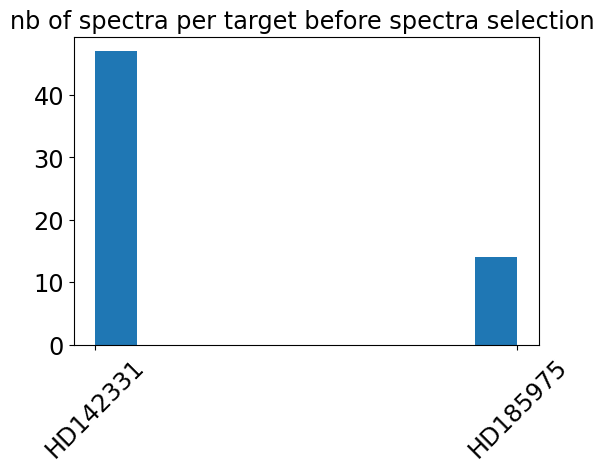

In [24]:
fig = plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target before spectra selection ")

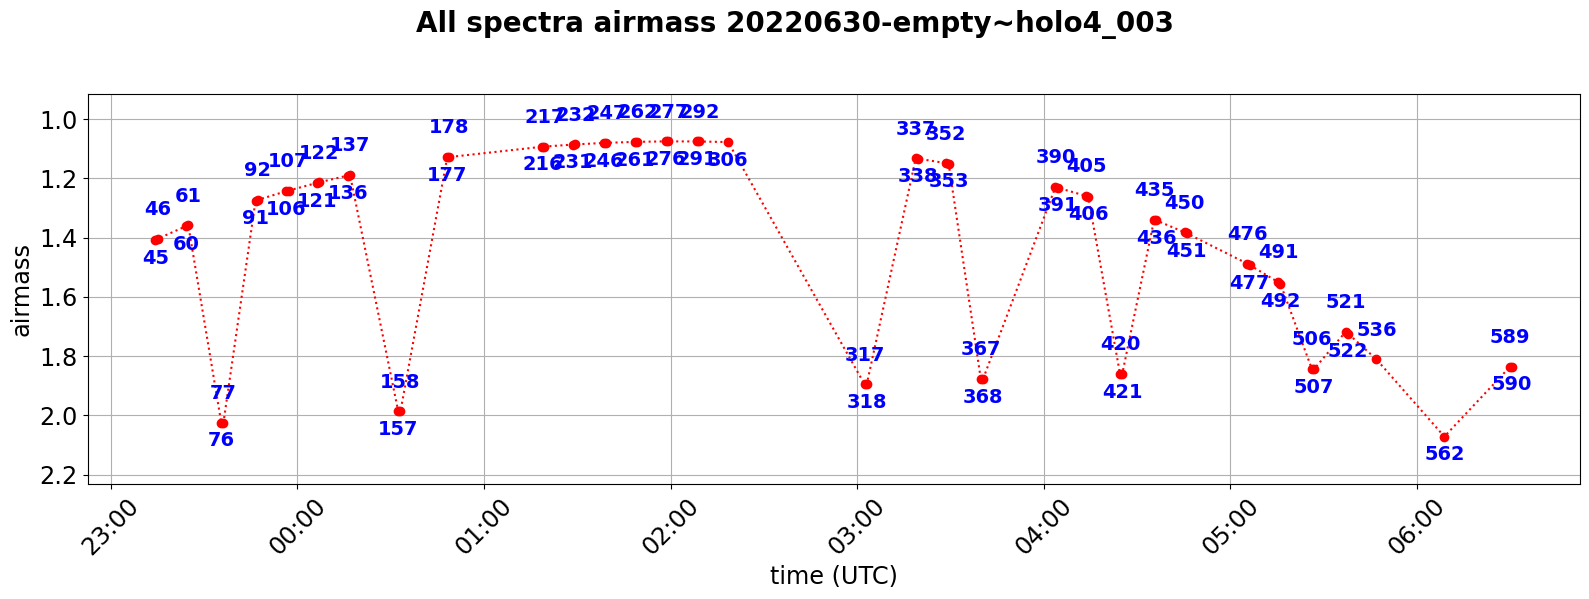

In [25]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['dateobs'] ]
numbers = infos['number'].values
airmasses = infos['airmass'].values
N= len(numbers)

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)


# Create rectangle x coordinates
startTime = all_datetime[0]
endTime =  all_datetime[-1]

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start



fig=plt.figure(figsize=(16,6))
ax=fig.add_subplot(111)
#ax.plot(all_datetime,grey_attenuation,'bo:')
#ax.grid()
#plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_tick_params(rotation=45)
#ax.set_xlabel("time (UTC)")
#ax.set_title(f"Grey attenuation : {DATE} ({filterdisperser}, {target})")
#ax.set_ylabel("attenuation")
#ax2 = ax.twinx()

y_shift= 0.08

ax2=ax
ax2.plot(all_datetime,airmasses,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
# Plot rectangle
#rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
#ax2.add_patch(rect)   
ax2.invert_yaxis()
ax2.grid()


for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax2.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    
the_title = f"All spectra airmass {DATE}-{filterdisperser}"
plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_02-{DATE}-{filterdisperser}-airmasses.pdf"
plt.savefig(fig_filename)
plt.show()

## Quick view of Auxtel Spectra

In [26]:
N=len(infos)
# number of columns
NX=3
# numbers of rows
NY=N/NX

if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

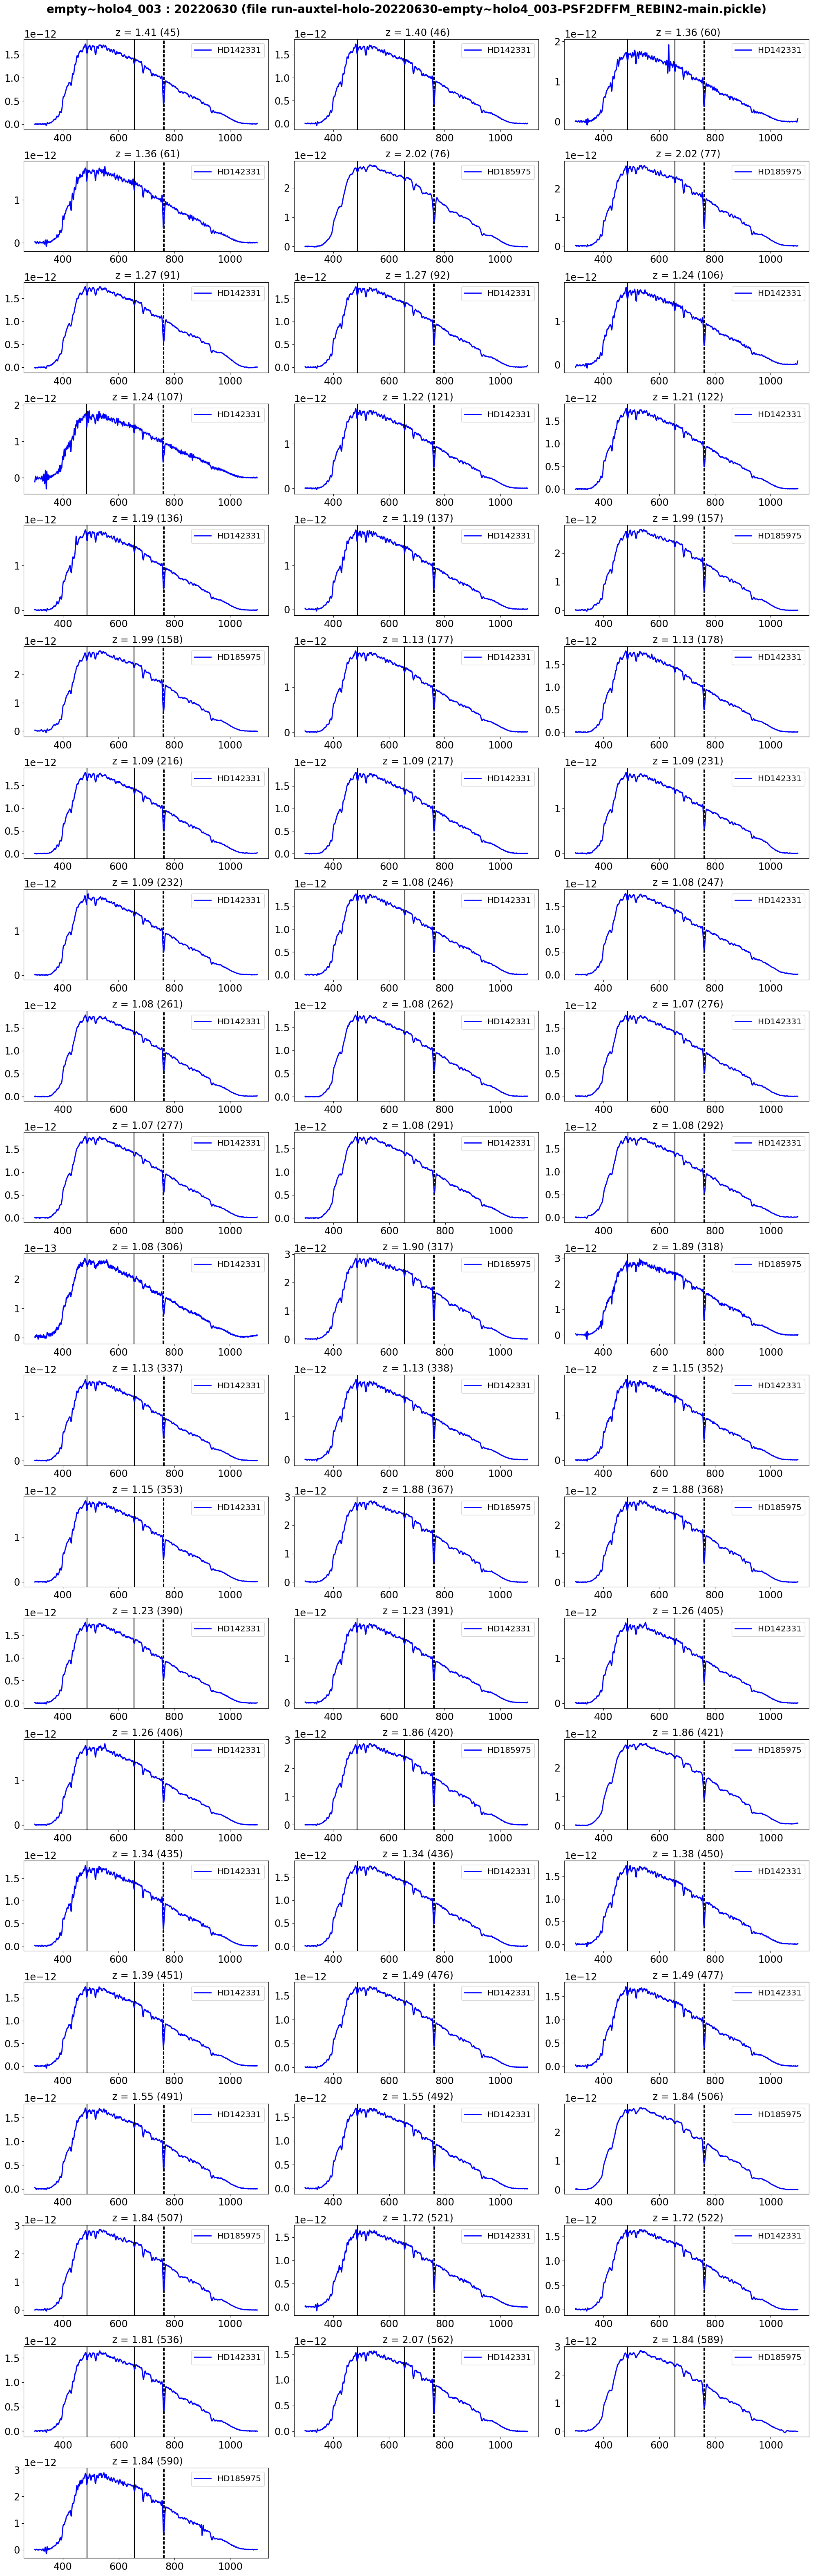

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["object"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-',lw=2 ,color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    
    ax.axvline(HBETA.wavelength,linestyle="-",color="k")
    ax.axvline(HALPHA.wavelength,linestyle="-",color="k")
    
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.legend()
the_title = f"{the_filtertype} : {the_date} (file {filename_spectra})"
the_figname =f"fig_01_{the_date}_{the_filtertype}"

plt.suptitle(the_title,fontsize=20,fontweight='bold',y=1)
plt.tight_layout()
plt.savefig(the_figname)

In [28]:
list_of_badnums = [60,306]

In [29]:
infos, all_spectra = GetSpectraFiltered(spectra_content,list_of_bad_spectra=list_of_badnums)

Remove spectrum 2 for exposure 60
Remove spectrum 30 for exposure 306


In [32]:
NBSPECTRA=len(infos)

## Closer look at feature spectra

## Load absorption pattern

In [30]:
df = pd.read_csv("../data/atmosphere/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_79895/360324760.py:84: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


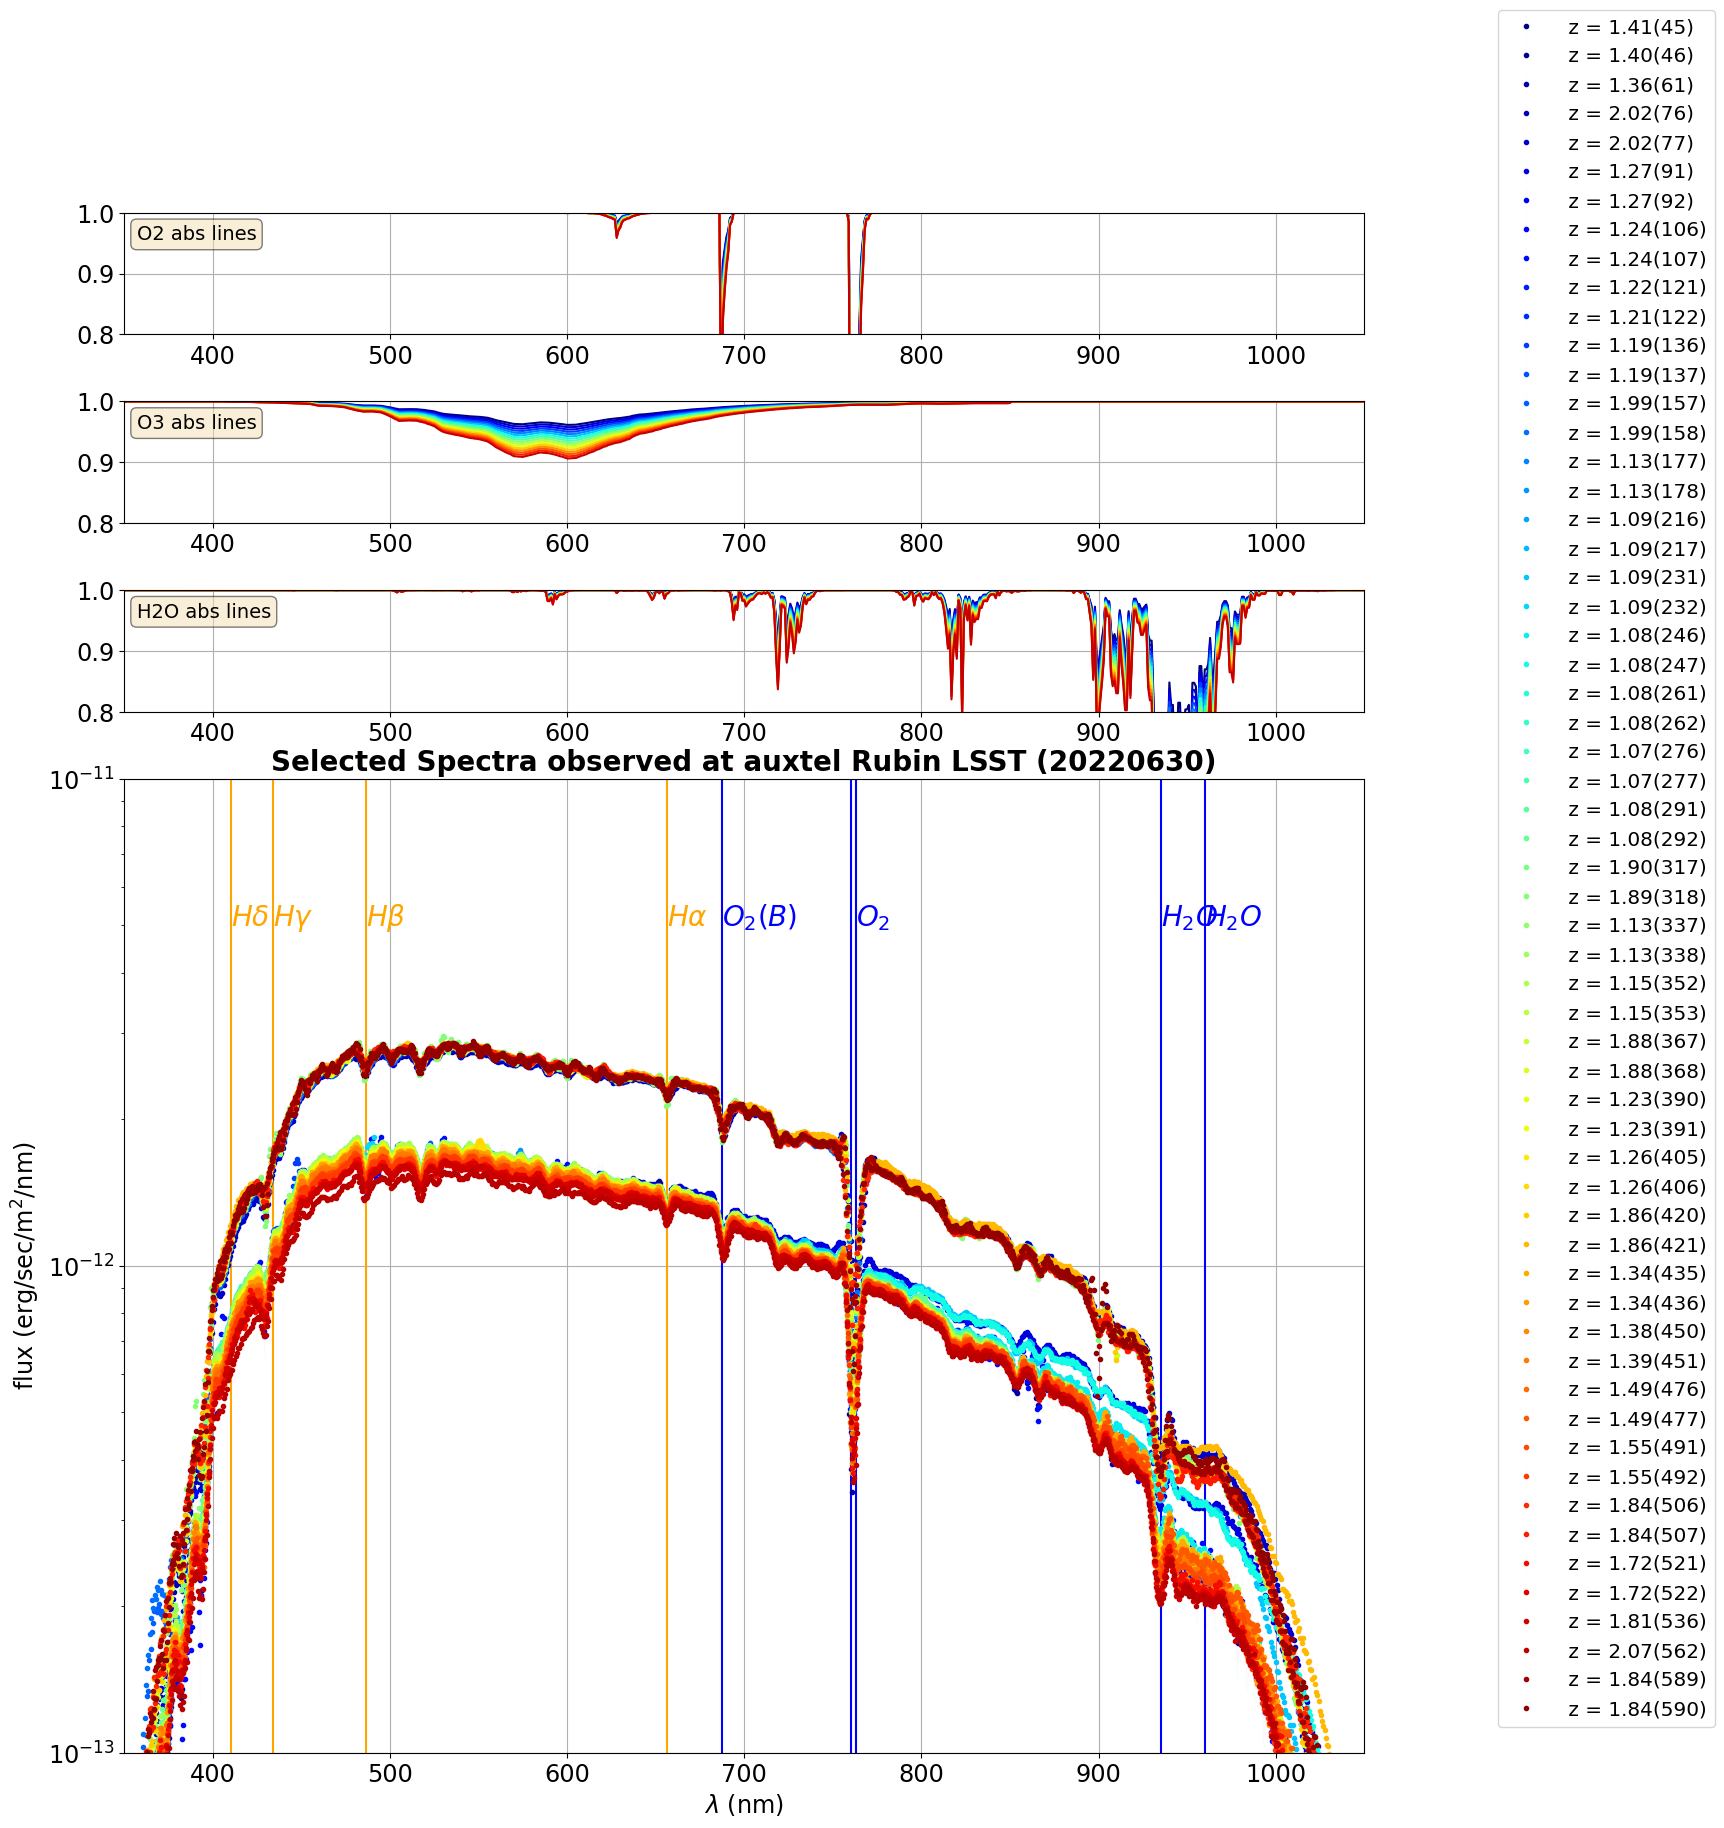

In [33]:
NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=(16,20))
title =f"Spectra (hologram) {SITE} ({DATE})"

gs = gridspec.GridSpec(4, 1,height_ratios=[0.5,0.5,0.5,4] ,figure=fig)


#=========================================================== O2    
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)
main_ax = ax

#=========================================================== Ozone
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#=========================================================== H2O
ax=fig.add_subplot(gs[2,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#=========================================================== spectra
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
all_numbers = infos['number'].values

# loop on spectra
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    the_number = all_numbers[ifile]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')

ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(bbox_to_anchor=(1.1, 1.8),ncol=1)


# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)

plt.tight_layout()


# SED

In [50]:
list_sed_names = infos.object.unique()
dict_f_sed = {}
dict_name_sed = {}

In [53]:
for targetid in list_sed_names:
    sedfilename = dict_sedfilename[targetid]
    
    hdul = fits.open(os.path.join(path_calspec,sedfilename))
    
    the_targetname = hdul[0].header['TARGETID']
    seddata = hdul[1].data
    
    sed_w=seddata["WAVELENGTH"]/10
    sed_f=seddata["FLUX"]*10
    sed_idx=np.where(np.logical_and(sed_w> WLMINSEL ,sed_w< WLMAXSEL))[0]
    sed_w=sed_w[sed_idx]
    sed_f=sed_f[sed_idx]
    
    # interpolation function
    f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")
    
    dict_name_sed[targetid] = the_targetname
    dict_f_sed[targetid] = f_sed 
    

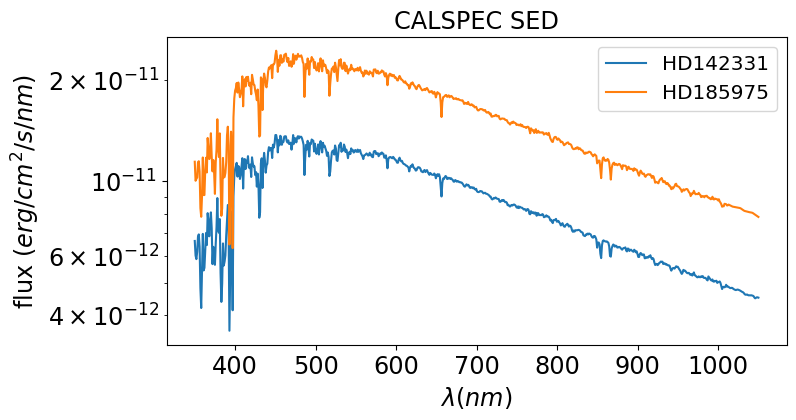

In [54]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():

    sed = f_sed(WL)
    sed_m=-2.5*np.log10(sed)
    
    label= f"{targetid}"
    ax.plot(WL,sed,label=label)
    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

# Simulate atmospheric transparency

In [60]:
NBINFOS = len(infos)
dict_func_atm = {}
pwv0 = 4
oz0 = 300.
ncomp=0

for ispec in range(NBINFOS):
    the_infos = infos.iloc[ispec]
    the_airmass = the_infos["airmass"]
    the_number = the_infos["number"]
    
    transm = emul.GetAllTransparencies(WL,the_airmass,pwv0,oz0,ncomp=ncomp,flagAerosols=False)
    dict_func_atm[the_number] = interpolate.interp1d(WL,transm,bounds_error=False,fill_value="extrapolate")

In [56]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBINFOS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBINFOS), alpha=1)

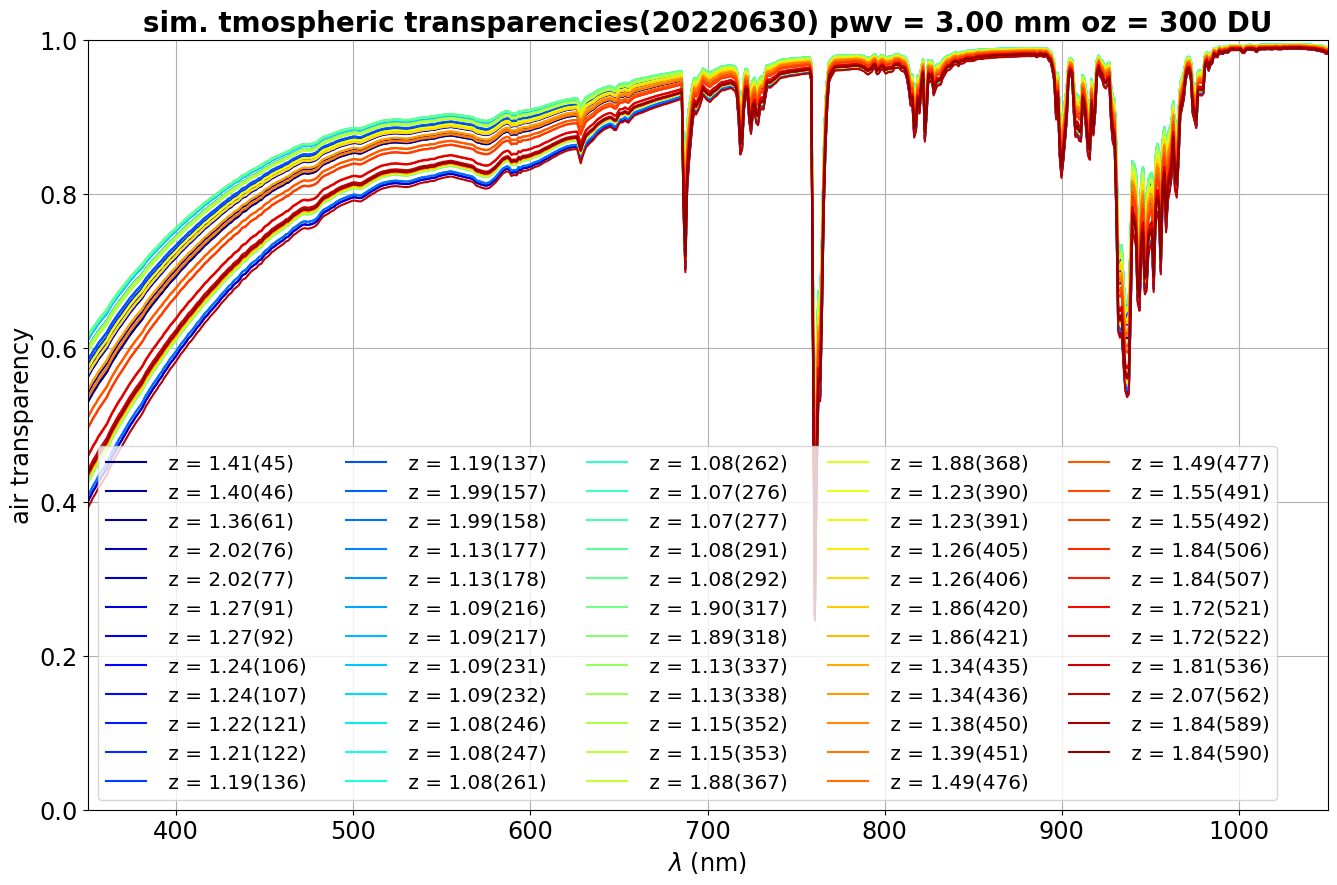

In [59]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for isim in np.arange(NBINFOS):
    
    airmassvalue = infos.iloc[isim]["airmass"]
    the_number = infos.iloc[isim]["number"]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    atm = dict_func_atm[the_number](WL)
    
    ax.plot(WL,atm, color=all_colors[isim],label=label_airmass)

ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("air transparency")
title=f"sim. tmospheric transparencies({DATE}) pwv = {pwv0:.2f} mm oz = {oz0:.0f} DU"
ax.set_title(title,fontsize=20,fontweight='bold')

ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.set_ylim(0.,1)
ax.legend(loc="lower left",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0.5))
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.6))


# Take Home Message